# TL;DR

In [89]:
import json
import re
from concurrent.futures import ThreadPoolExecutor
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import tiktoken
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from transformers import BertTokenizerFast

# spacy.cli.download("en_core_web_sm")

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
with open("../data/01_primary/one_hot_mapping.json", "r") as f:
    mapping = json.load(f)

with open("../data/01_primary/abs_decoder_domain_specific.json", "r") as f:
    decoder = json.load(f)

In [4]:
df1b_train = pd.read_parquet("../data/asrs_data_primary_train.parquet")
df1b_trained_filtered = df1b_train.copy()

In [7]:
berttokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tiktokenizer = tiktoken.get_encoding("cl100k_base")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Count tokens per narratives

## W/ berttokenizer

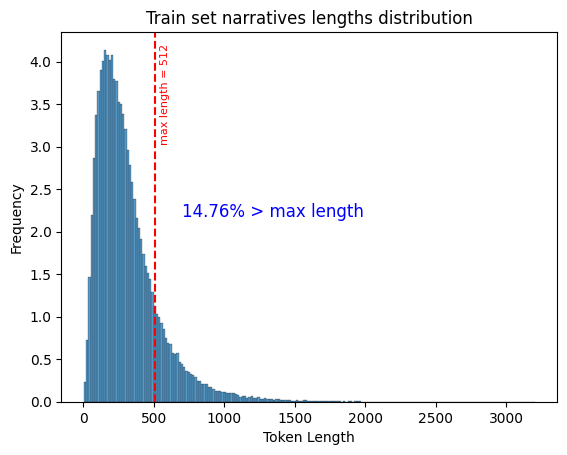

In [ ]:
bert_count = [
    len(berttokenizer.encode(narrative)) for narrative in df1b_train.narrative.tolist()
]
sns.histplot(bert_count, bins=200, stat="percent")
plt.axvline(x=512, color="red", linestyle="--")
plt.text(
    512 + 30,
    plt.ylim()[1] * 0.7,
    f"max length = 512",
    color="red",
    rotation=90,
    fontdict={"fontsize": 8},
)
plt.text(
    700,
    plt.ylim()[1] * 0.5,
    f"{(len(np.where(np.array(bert_count)>512)[0])/len(bert_count)) * 100:.2f}% > max length",
    color="blue",
    fontdict={"fontsize": 12},
)
plt.title("Train set narratives lengths distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

## W/ tiktokenier

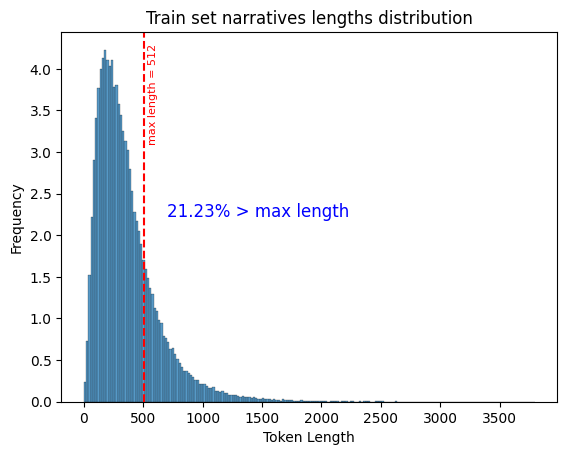

In [ ]:
tik_count = [
    len(tiktokenizer.encode(narrative)) for narrative in df1b_train.narrative.tolist()
]
sns.histplot(tik_count, bins=200, stat="percent")
plt.axvline(x=512, color="red", linestyle="--")
plt.text(
    512 + 30,
    plt.ylim()[1] * 0.7,
    f"max length = 512",
    color="red",
    rotation=90,
    fontdict={"fontsize": 8},
)
plt.text(
    700,
    plt.ylim()[1] * 0.5,
    f"{(len(np.where(np.array(tik_count)>512)[0])/len(tik_count)) * 100:.2f}% > max length",
    color="blue",
    fontdict={"fontsize": 12},
)
plt.title("Train set narratives lengths distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

# Remove stop words

In [60]:
def remove_stopwords(text: "str", lang: "spacy.Language"):
    pattern = re.compile(r"\s+([.,!?;:])")
    docs = nlp(text)
    filtered = " ".join([token.text for token in docs if not token.is_stop])
    filtered = pattern.sub(r"\1", filtered)
    return filtered

In [61]:
df1b_trained_filtered.loc[[True] * len(df1b_trained_filtered), "narrative"] = (
    df1b_trained_filtered.narrative.apply(lambda t: remove_stopwords(text=t, lang=nlp))
)

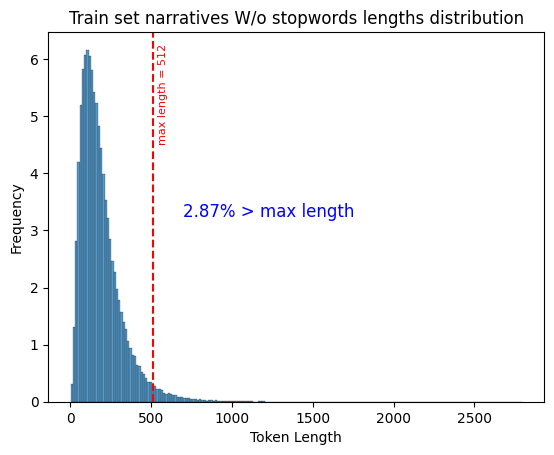

In [62]:
bert_count = [
    len(berttokenizer.encode(narrative))
    for narrative in df1b_trained_filtered.narrative.tolist()
]
sns.histplot(bert_count, bins=200, stat="percent")
plt.axvline(x=512, color="red", linestyle="--")
plt.text(
    512 + 30,
    plt.ylim()[1] * 0.7,
    f"max length = 512",
    color="red",
    rotation=90,
    fontdict={"fontsize": 8},
)
plt.text(
    700,
    plt.ylim()[1] * 0.5,
    f"{(len(np.where(np.array(bert_count)>512)[0])/len(bert_count)) * 100:.2f}% > max length",
    color="blue",
    fontdict={"fontsize": 12},
)
plt.title("Train set narratives W/o stopwords lengths distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

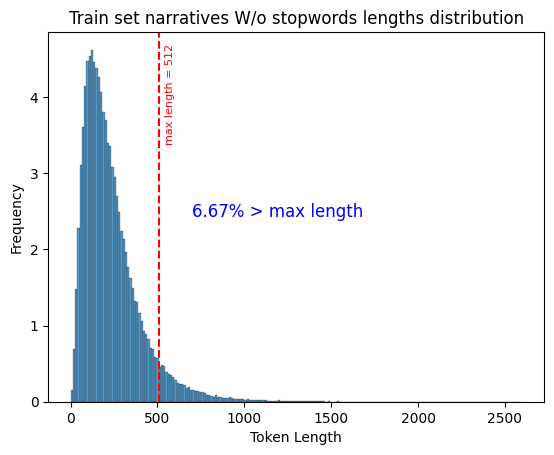

In [64]:
tik_count = [
    len(tiktokenizer.encode(narrative))
    for narrative in df1b_trained_filtered.narrative.tolist()
]
sns.histplot(tik_count, bins=200, stat="percent")
plt.axvline(x=512, color="red", linestyle="--")
plt.text(
    512 + 30,
    plt.ylim()[1] * 0.7,
    f"max length = 512",
    color="red",
    rotation=90,
    fontdict={"fontsize": 8},
)
plt.text(
    700,
    plt.ylim()[1] * 0.5,
    f"{(len(np.where(np.array(tik_count)>512)[0])/len(tik_count)) * 100:.2f}% > max length",
    color="blue",
    fontdict={"fontsize": 12},
)
plt.title("Train set narratives W/o stopwords lengths distribution")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.show()

# CLEAN OUT FREQUENT WORDS, DECODE ABBS AND CLEAN USELESS PUNCS

## Compute TFIDF for filtering

In [65]:
vectorizer = TfidfVectorizer(dtype=np.float32, lowercase=False, norm="l1")

df = pd.DataFrame.sparse.from_spmatrix(
    vectorizer.fit_transform(raw_documents=df1b_trained_filtered.narrative.tolist()),
    columns=vectorizer.get_feature_names_out(),
)

##  decode abbs

esc_abb = escaped_terms = [re.escape(term) for term in decoder.keys()] + [re.escape(term.lower()) for term in decoder.keys()] + [re.escape(term.capitalize()) for term in decoder.keys()]
pattern = re.compile(r"(" + '|'.join(esc_abb) + r")")

In [66]:
def build_decoder_pattern(decoder: dict) -> re.Pattern:
    terms = set()
    for key in decoder:
        terms.update({key, key.lower(), key.capitalize()})

    escaped_terms = [r"(?<!\w)" + re.escape(term) + r"(?!\w)" for term in terms]
    return re.compile(r"(" + "|".join(escaped_terms) + r")")

In [67]:
def decode_abs(text: "str", pattern: "re.Pattern", decoder: "dict[str, str]"):
    matched_abbs = [
        (abb.upper() if not abb.isupper() else abb)
        for abb in set(pattern.findall(text.strip().replace(" / ", "/")))
    ]
    for abb in matched_abbs:
        text = text.replace(abb, decoder[abb])
    return text

## Clean punc

In [68]:
def clean_punc(text: "str"):
    t = re.sub(
        r"([a-zA-Z0-9])\s+([.,!?;:])", r"\1\2", text
    )  # Coller la ponctuation au mot précédent
    t = text = re.sub(
        r"(\w)([!?])\2+", r"\1\2", t
    )  # Réduire les ponctuations répétées identiques (!!, ??) à une seule
    t = re.sub(
        r"(\w)[!?]{2,}", r"\1?", t
    )  # Remplacer les séquences mixtes de !? ou ?! ou !?!? etc. par ?
    t = re.sub(
        r"([.,;!?])[.,;!?]{2,}", r"\1", t
    )  # Supprimer les groupes de ponctuation trop longs (ex: "!!!", ",,,", etc.)
    # Supprimer les ponctuations orphelines (début ou fin ou entre espaces)
    t = re.sub(r"(^|\s)[.,;!?](?=\s|$)", r"\1", t)
    t = re.sub(r"^[.,;!?]\s+", "", t)
    # Nettoyer les espaces multiples
    clned_text = re.sub(r"\s{2,}", " ", t).strip()
    return clned_text


clean_punc(
    "Bonjour , comment ça va ? Très bien , merci ! ;,, . Bonjour ; ensuite. Incroyable!! Quoi?? C'est fou!!?? Non?! ok. Bonjour ?!;;!! ok. Bonjour?!;;!!"
)
#

"Bonjour, comment ça va? Très bien, merci! Bonjour; ensuite. Incroyable! Quoi? C'est fou? Non? ok. Bonjour? ok. Bonjour?"

## Compute filterings

In [ ]:
def process_single_narrative(
    i: "int",
    text: "str",
    lang: "spacy.Language",
    tdidf: "pd.DataFrame",
    code_patterns: "re.Pattern",
    decoder: "dict[str, str]",
    thd: "float",
    decode: "bool" = True,
):
    tdidf_row = tdidf.iloc[i]
    words = tdidf_row[tdidf_row > thd]

    text, lang, tdif_row, code_patterns, decoder, decode = args
    docs = lang(text)
    tokens = []
    filtered_tokens = tdif_row[tdif_row > 0].index
    for token in docs:
        if token.is_punct:
            tokens.append(token.text)
        else:
            if token.text in filtered_tokens:
                tokens.append(
                    decode_abs(text=token.text, pattern=code_patterns, decoder=decoder)
                    if decode
                    else token.text
                )
    return clean_punc(" ".join(tokens)).lower()


def filter_narratives(
    narratives: "list[str]",
    lang: "spacy.Language",
    tdidf: "pd.DataFrame",
    code_patterns: "re.Pattern",
    decoder: "dict[str, str]",
    thd: "float" = 0.0,
    decode: "bool" = True,
    max_workers: "int | None" = None,
):
    func = partial(
        process_single_narrative,
        tdidf=tdidf,
        lang=lang,
        code_patterns=code_patterns,
        decoder=decoder,
        decode=decode,
    )
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(
            tqdm(
                executor.map(lambda args: func, enumerate(narratives)),
                total=len(narratives),
                desc="Filtering...",
            )
        )
    return results

In [72]:
pattern = build_decoder_pattern(decoder)

## W/o Decoding ABBS

In [88]:
filtered_narratives = filter_narratives(
    narratives=df1b_trained_filtered.narrative.tolist(),
    lang=nlp,
    tdif=df,
    code_patterns=pattern,
    decoder=decoder,
    decode=False,
)

Preparing obs...:   0%|          | 0/121196 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import time


def say_hello(name):
    print(f"Hello, {name}!")
    time.sleep(1)
    return f"Greeting sent to {name}"


names = ["Alice", "Bob", "Charlie", "Dana"]

with ThreadPoolExecutor(max_workers=4) as executor:
    results = executor.map(say_hello, names)

for result in results:
    print(result)

# ONE HOT

In [ ]:
def one_hot(text: "str", mapping: "dict[str, int]"):
    num_labels = [0] * len(mapping)
    labels = [label.strip().replace(" / ", "/") for label in text.split(";")]
    for label in labels:
        num_labels[mapping[label]] = 1
    return num_labels

df1b.loc[[True]*len(df1b) ,"anomaly"] = df1b["anomaly"].apply(lambda t: one_hot(text=t, mapping=one_hot_mapping))